<a href="https://colab.research.google.com/github/SERVIR/flood_mapping_intercomparison/blob/main/notebooks/Module_5_Collecting_Reference_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

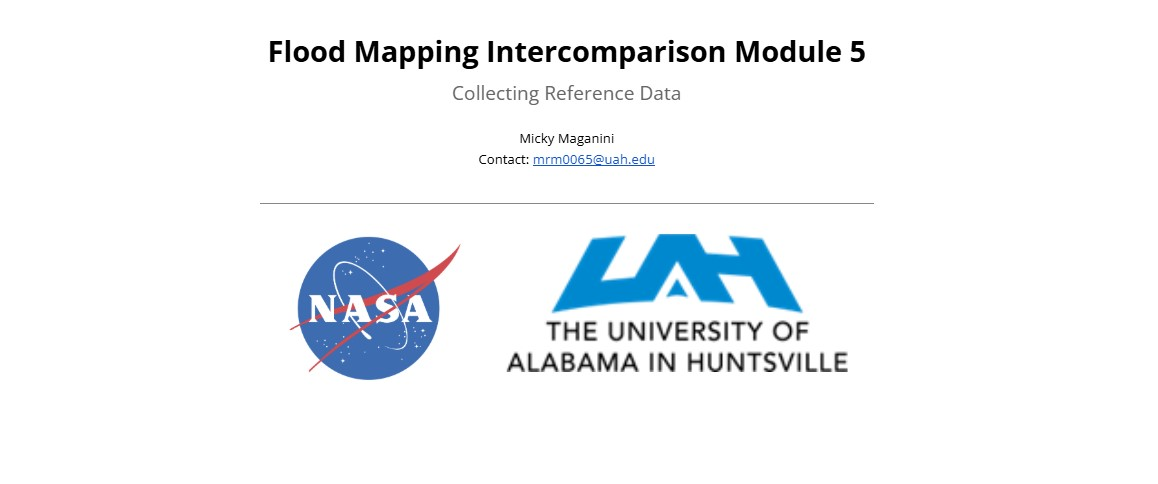

# Introduction

Now that we have all of our flood maps, we want to collect some "ground truth" data to assess the performance of the flood products. I put ground truth in quotes because in this case we will be conducting visual image interpretation based on imagery obtained on our date of interest. Thus, this data is of lower quality than real ground truth data collected in the field. However, collecting reference data in this way is much more feasible, especially since we aim to validate various flood events across the world and in the past. If you ran Section_B, you will have high-resolution optical imagery obtained from Planet. If you do not have access to this commercial imagery, you can use Sentinel-1 or HLS data as shown in this module. We will use the platform Collect Earth Online to collect our reference data.

# Step 1: Define global variables

### MODIFIABLE VARIABLE ALERT

Change the variables below to suit your needs.

In [ ]:
# Google Earth Engine Directory
parent_directory = "users/mickymags/semifinal_fmi_cambodia_20241001/" # Make sure this ends in a slash
my_gee_project= 'servir-sco-assets'
my_gdrive_folder = 'Flood_Intercomparison'
doi = "2024-10-01"

# Step 2: Import packages

In [ ]:
import numpy as np
import pandas as pd
from google.colab import drive
import matplotlib.pyplot as plt
import ee
import geemap

In [ ]:
ee.Authenticate()

ee.Initialize(project = 'servir-sco-assets')

In [ ]:
day = ee.Date(doi)
daylater = day.advance(1, 'day')
aoi = ee.FeatureCollection(parent_directory + 'aoi')

In [ ]:
aoi_centroid = aoi.geometry().centroid()
lon = aoi_centroid.getInfo()["coordinates"][0]
lat = aoi_centroid.getInfo()["coordinates"][1]

In order to pull imagery into Collect Earth Online, we will need to host it on a database. In this case Google Earth Engine will serve as this database. So our workflow will be as follows:

* Get Sentinel-1 imagery over our date of interest
  * Export it to a Google Earth Engine Image Collection Asset
* Get HLS imagery over our date of interest
  * Generate a normalized difference water index (NDWI) image based on HLS. More info on NDWI later.
  * Export both the true color imagery as well as NDWI imagery to a Google Earth Engine Asset
* Pull all of the above imagery into Collect Earth Online.
* Create our project in Collect Earth Online.


# Step 3: Get Sentinel-1 imagery from the date of interest

In [ ]:
s1 = ee.ImageCollection("COPERNICUS/S1_GRD")

s1_filt = s1.filterBounds(aoi).filterDate(day, daylater).select('VV')

num_s1 = s1_filt.size().getInfo()

s1_asset_id = parent_directory + 'reference/s1_mosaic'

s1_ic = []

#s1_export_folder = parent_directory + 'reference/s1ref/'

for t in range(num_s1):
  s1_img_of_int = ee.Image(s1_filt.toList(num_s1).get(t))

  s1_ic.append(s1_img_of_int)
  #asset_eyedee = s1_export_folder + 'pt' + str(j)
  #geemap.ee_export_image_to_asset(s1_img_of_int, description = 'sentinel1_reference', assetId=asset_eyedee, scale=10, crs='EPSG:32633',maxPixels=1e13)

s1_mosaic = ee.ImageCollection(s1_ic).mosaic()
geemap.ee_export_image_to_asset(s1_mosaic, description = 'sentinel1_reference_mosaic', assetId=s1_asset_id, scale=10, crs='EPSG:32633',maxPixels=1e13)


In [ ]:
s1_filt.size().getInfo()

# Step 4: Get HLS imagery from the date of interest

In [ ]:
# Obtain Sentinel-2 and Landsat-8 imagery from Google Earth Engine
hls_s2 = ee.ImageCollection("NASA/HLS/HLSS30/v002")
hls_l8 = ee.ImageCollection("NASA/HLS/HLSL30/v002")

hls = hls_s2.merge(hls_l8)

hls_filt = hls.filterBounds(aoi).filterDate(day, daylater)

In [ ]:
# Filter Sentinel-2 and Landsat-8 to the area of interest and date of interest
hls_s2_filt = hls_s2.filterBounds(aoi).filterDate(day, daylater)
hls_l8_filt = hls_l8.filterBounds(aoi).filterDate(day, daylater)

In [ ]:
# See how many images are in our Sentinel-2 image collection
hls_s2_filt.size().getInfo()

In [ ]:
# See how many images are in our Landsat-8 image collection
hls_l8_filt.size().getInfo()

In [ ]:
# Visualize the Landsat-8 and Sentinel-2 Imagery
Map = geemap.Map(center = (lon, lat), zoom=4)

Map.addLayer(hls_s2_filt)
Map.addLayer(hls_l8_filt, {}, 'HLS L8')
Map.addLayer(aoi);
Map.addLayerControl()
Map

In [ ]:
hls_mos_pt1 = hls_filt.mosaic()
hls_mos_pt1_proj = hls_mos_pt1.projection().getInfo()
hls_mos_pt1_proj

In [ ]:
# Get the projection of the HLS image
my_proj = hls_filt.first().projection().crs().getInfo()
my_proj

Create an NDWI image for each HLS image

In [ ]:
num_hls = hls_filt.size().getInfo()

hls_ndwi_asset_id = parent_directory + 'reference/hls_ndwi_mosaic'
hls_asset_id = parent_directory + 'reference/hls_mosaic'

hls_ic = []
hls_ndwi_ic = []

# using a for loop, calculate the NDWI image
for q in range(num_hls):
  #HLS image of interest
  my_hls = ee.Image(hls_filt.toList(num_hls).get(q))
  hls_ic.append(my_hls)

  my_hls_ndwi = my_hls.normalizedDifference(['B3', 'B8A'])
  hls_ndwi_ic.append(my_hls_ndwi)

hls_mosaic = ee.ImageCollection(hls_ic).mosaic()
hls_ndwi_mosaic = ee.ImageCollection(hls_ndwi_ic).mosaic()


Export the HLS truecolor imagery

In [ ]:
hls_export_folder = parent_directory

for k in range(hls_filt.size().getInfo()):
  # Get the hls image of interest from the above list we created
  hls_img_of_int = ee.Image(hls_filt.toList(hls_filt.size().getInfo()).get(k))

  # Define a unique asset ID
  hls_asset_id = hls_export_folder + 'pt' + str(k)

  # Export the image to Earth Engine
  geemap.ee_export_image_to_asset(hls_img_of_int, assetId=hls_asset_id, scale=30, crs=my_proj, maxPixels=1e13)

The exports above will take a couple minutes to finish exporting. Once they have finished exporting, do the following steps for each image collection

1. Navigate to the GEE Code Editor
2. Click Assets in the top left
3. Navigate to the image collection asset of interest and click on it.
4. In the bottom left of the popup window, click the copy icon next to the text that says "ImageCollection ID"
5. Click paste in the corresponding variable name below
6. In the GEE window, Click Share in the upper right corner of the popup
7. Click the box that says "Anyone can read". This will allow Collect Earth Online to read this asset when we import it.



## MODIFIABLE VARIABLE ALERT

In [ ]:
s1_asset_name = 'users/mickymags/flood_intercomparison_chad_09_26_take2/reference/s1ref'
hls_asset_name = 'users/mickymags/flood_intercomparison_chad_09_26_take2/reference/hls_ref'
hls_ndwi_asset_name = 'users/mickymags/flood_intercomparison_chad_09_26_take2/reference/hls_ndwi'

Now let's add our image collections to the map. When we import imagery from Google Earth Engine into Collect Earth Online, we'll need to know two things:

1. The asset ID of the image/image collection we want to pull in
2. Some visualization parameters.

Visualization parameters include the bands of the image we want to visualize, as well as the min and max value. We know which bands we want to visualize, but the minimum and maximum may be different depending on the region of interest. We can use the stretch function in the map display to find some good min/max values.

In [ ]:
initial_s1_vp = {'bands': ['HH']}         # We'll select the VV band here because it is better at identifying water

initial_hls_vp = {'bands': ['B4', 'B3', 'B2']}

intial_hls_ndwi_vp = {'bands': ['nd'], 'min': -1 , 'max': 1}  # For NDWI we know our min and max values

In [ ]:
s1 = ee.ImageCollection(s1_asset_name)
hls = ee.ImageCollection(hls_asset_name)
hls_ndwi = ee.ImageCollection(hls_ndwi_asset_name)

In [ ]:
Map = geemap.Map(center = (lon, lat), zoom=4)

Map.addLayer(s1, initial_s1_vp, 'Sentinel-1')
Map.addLayer(hls, initial_hls_vp, 'Harmonized Landsat Sentinel')
Map.addLayer(aoi)

Map.addLayerControl()
Map

For each layer except NDWI, click the gear icon next to the layer name and click different stretch options until you like how the visualization appears.

* For HLS, the 1 sigma stretch seems to work good for me.
* For S1, I use the 98% stretch in most cases

Once you like the visualization, enter in the min and max values into the corresponding variables below. (You can see the min and max next to the "Range" text in the map visualization panel)

In [ ]:
hls_final_vp = {"bands": ["B4", "B3", "B2"],"min":0,"max":0.3}
s1_final_vp = {"bands": ["VV"], "min": -18.5, "max": -3.5}
hls_ndwi_final_vp = {"bands": ["nd"], "min": -1 , "max": 1}

Note that Collect Earth Online requires you to use double quotes. If you use single quotes you will get an error

Now that we have our visualization parameters, we're ready to import our imagery into Collect Earth Online. Follow the steps below to do so.

1. Navigate to Collect Earth Online((https://app.collect.earth/home))
2. Click Login in the upper right
3. Create or join your project in the upper left.
4. Navigate to your project homepage
5. Click Imagery
6. Click "GEE Image Collection Asset".
7. Type in a title. This can be anything you want
8. Enter the start and end date for which your data was filtered. In my case both the start date and end date are the same date
7. Under Asset Id, enter in the variable you typed in for "s1_asset_name". Do not include the quotes
8. Under visualization parameters, copy and paste in the visualization parameters from above, including the curly braces {}

# Step 5: Create our Collect Earth Online project

1. Navigate to your Google Drive
2. Download to the stratified sample CSV we exported to google drive. It should be called something similar to "upload_ready_stratified_sample.csv"
3. Navigate to Collect Earth Online
4. Go to your project homepage
5. Click Create new Project
6. Enter a name and description for your project.
7. Click "Collect Plot Confidence" if you intend to collect the confidence of your interpreter for each plot. Click Next
8. Click checkmarks next to all the imagery you want to use in this project. Click next.
9. Under the text that says "spatial distirubtion", select **CSV** from the dropdown menu.
10. Click Upload plot file. Navigate to the strat sample csv file you downloaded from Google Drive in step 2.
11. Under the text that says plot width, enter in 30. Click Next
12. Under the text that says "spatial distribution", click Center. Click Next.
13. Next to the text that says "Question text", type in "water?"
14. Click "Add survey question".
15. Enter in answers for "yes", "no", and "cloud". Make them different colors and click the save button to the left of the question and possible answers.
16. Click Next
17. Click Next again.
18. Click "I agree to the Terms of Service".
19. Click "Create Project"
20. Click "ok" on the popup
21. Click "Collect" to start Collecting project data.

# Step 6: Collect Reference Data

1. For each Plot, categorize the entire yellow square as either water, nonwater, or cloud.
2. For the purposes of our study, we consider any plots being more than 51% water to be of the "water" class. For any "mixed pixels", lower the confidence slider.
3. After collecting all plots, return to the project homepage.
4. Next to the project you collected data for, click the "P" to download the plot data.
5. Navigate to [Google Earth Engine](https://code.earthengine.google.com/)
6. Click the "Assets" tab in the top left
7. Click the red "new" button
8. Click "CSV" file
9. Click the red Select button and navigate to the plot data you downloaded in part 4.
10. Under the text that says "Asset ID", type in the path to your google earth engine folder and then type in "/reference_data". For example, my path reads "users/mickymags/flood_intercomparison_chad_09_25_take2/reference_data"
10. Under the text that says "X Column", type in "center_lon"
11. Under the text that says "Y column", type in "center_lat"
12. Click "upload"

We now have all of our flood maps and some reference data. Finally, in Module 6, we will conduct an accuracy assessment where we compare each of our flood maps to the reference data we collected in Collect Earth Online.